## **Wykrywanie naczyń dna siatkówki oka**

### *Biblioteki*

In [54]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

### *Funkcje*

In [55]:
def show_image(image, title=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title) if title else None
    plt.axis('off')
    plt.show()

### 0. Wczytanie obrazu

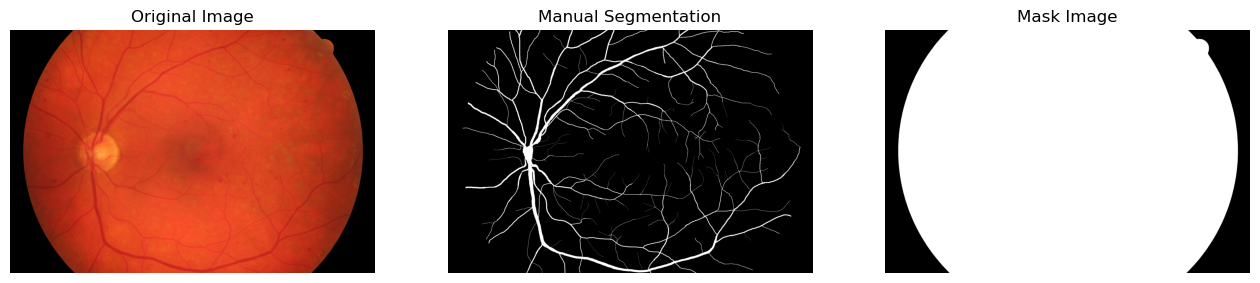

Szerokość obrazu: 3504
Wysokość obrazu: 2336
Szerokość obrazu maski: 3504
Wysokość obrazu maski: 2336


In [56]:
image_path = 'HRF-database/images/01_dr.JPG'
originalImage = cv2.imread(image_path)

segmentedImage_path = 'HRF-database/manual1/01_dr.tif'
segmentedImage = cv2.imread(segmentedImage_path)

mask_path = 'HRF-database/mask/01_dr_mask.tif'
maskImage = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(16, 12))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(segmentedImage, cv2.COLOR_BGR2RGB))
plt.title('Manual Segmentation')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(maskImage, cmap='gray')
plt.title('Mask Image')
plt.axis('off')

plt.show()

print("Szerokość obrazu:", originalImage.shape[1])
print("Wysokość obrazu:", originalImage.shape[0])

print("Szerokość obrazu maski:", maskImage.shape[1])
print("Wysokość obrazu maski:", maskImage.shape[0])


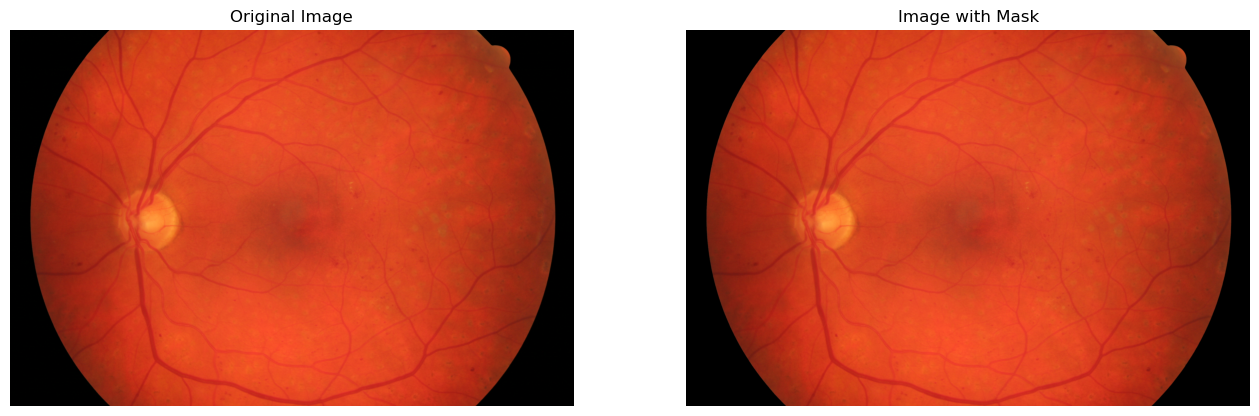

In [57]:
# to fix (usuwanie konturu oka widocznego po segmentacji)
# Perform bitwise AND between the original image and inverted mask to remove pixels outside the eye region
image_with_mask = cv2.bitwise_and(originalImage, originalImage, mask=maskImage)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_with_mask, cv2.COLOR_BGR2RGB))
plt.title('Image with Mask')
plt.axis('off')

plt.show()

### 1. Przetowrzenie obrazu

- usunięcie tła 

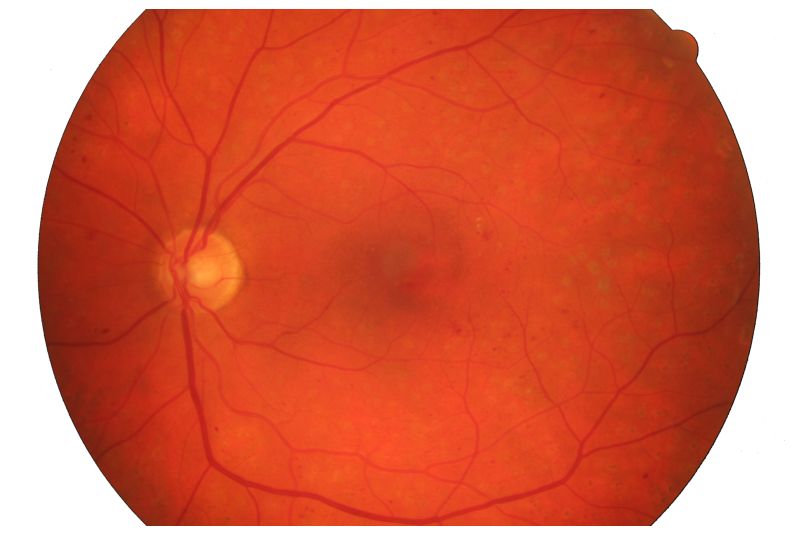

In [58]:
image = image_with_mask.copy()
threshold = 6 # Próg dla każdego kanału kolorów

image[np.where((originalImage < threshold).all(axis=2))] = [255, 255, 255] # transformacja

show_image(image)

- filtr Gamma

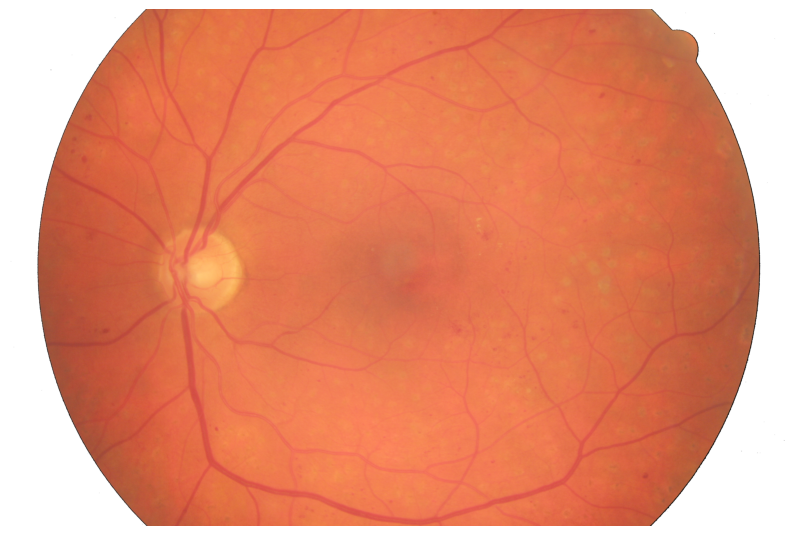

In [59]:
gamma = 1.75
gamma_corrected_image = np.uint8(((image / 255.0) ** (1 / gamma)) * 255)
show_image(gamma_corrected_image)

- Konwersja do skali szarości

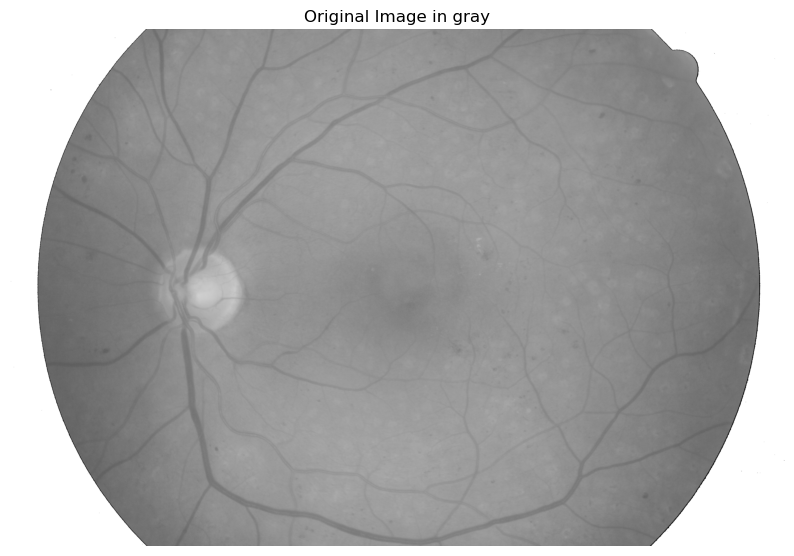

In [60]:
gray = cv2.cvtColor(gamma_corrected_image, cv2.COLOR_BGR2GRAY)
show_image(gray, title='Original Image in gray')

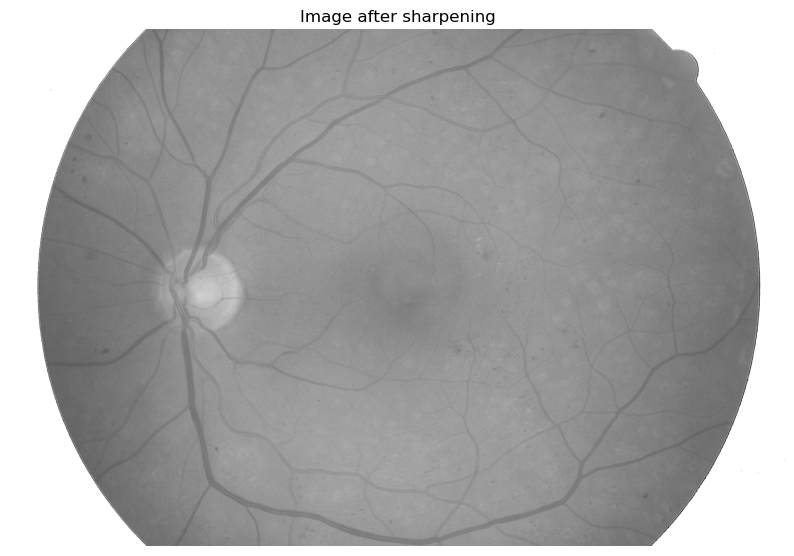

In [61]:
# Wyostrzenie obrazu
sharp_image = cv2.filter2D(gray, -1, np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]]))
show_image(sharp_image, title='Image after sharpening')

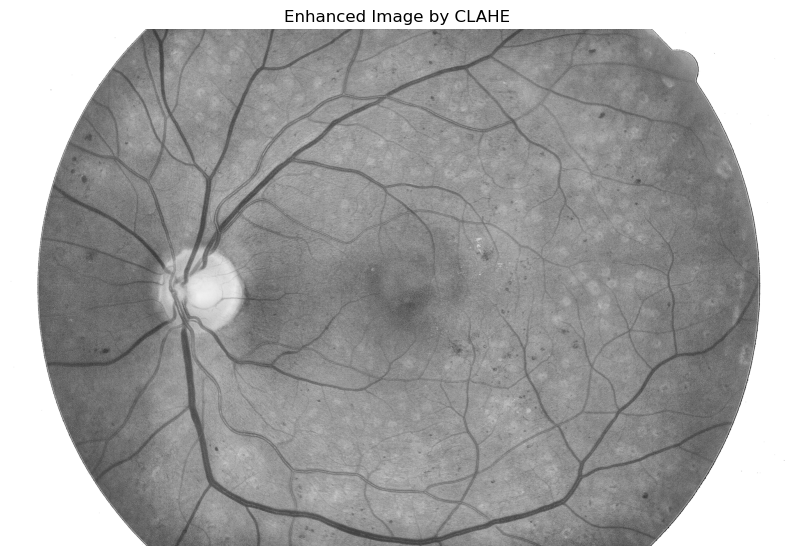

In [62]:
# Zwiększenie kontrastu
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced_image = clahe.apply(sharp_image)
show_image(enhanced_image, title='Enhanced Image by CLAHE') # Contrast Limited Adaptive Histogram Equalization

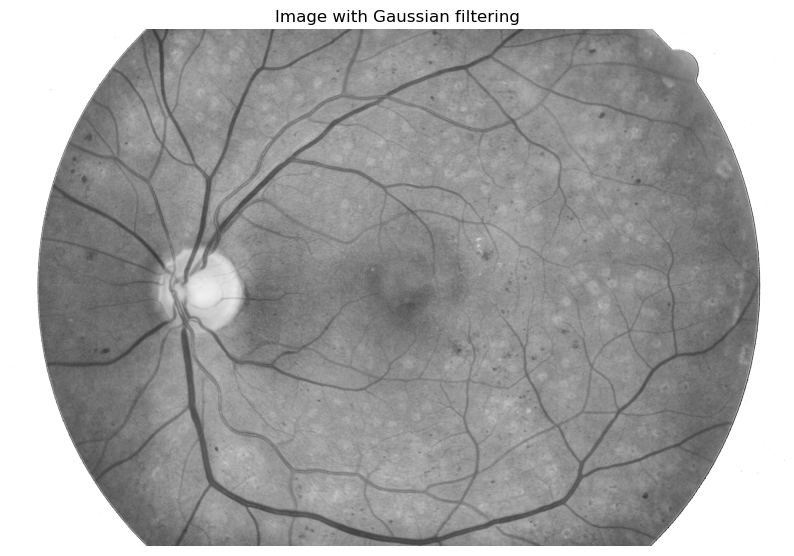

In [66]:
# Filtr bilateralny
bilateralFiltered = cv2.bilateralFilter(enhanced_image,9,50,50)
show_image(bilateralFiltered, title='Image with Gaussian filtering')

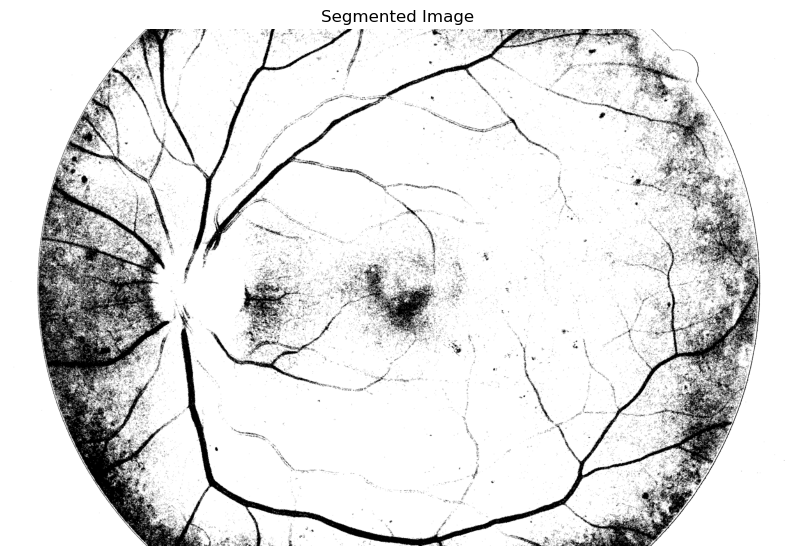

In [67]:
threshold_value = 110 # Ustalenie progu

_, segmented_image = cv2.threshold(bilateralFiltered, threshold_value, 255, cv2.THRESH_BINARY) # segmentacja poprzez progowanie

show_image(segmented_image, title='Segmented Image')

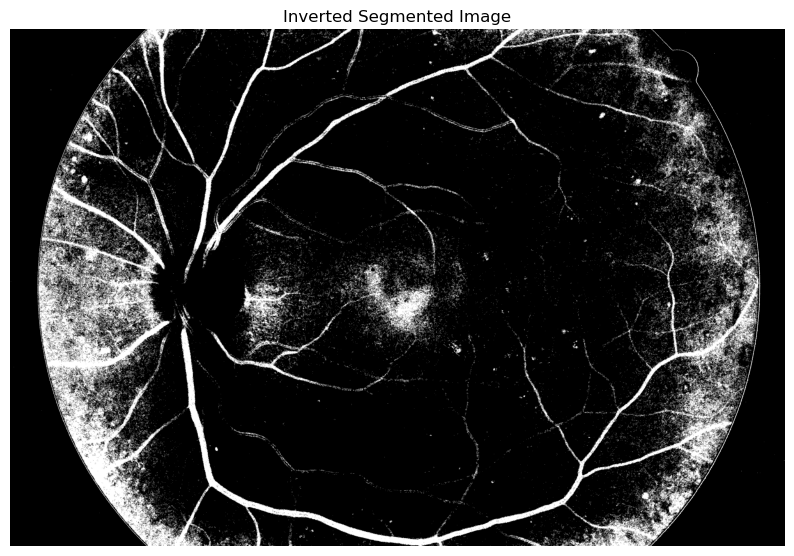

In [68]:
# Odwrócenie kolorów
inverted_segmented_image = 255 - segmented_image
show_image(inverted_segmented_image, title='Inverted Segmented Image')

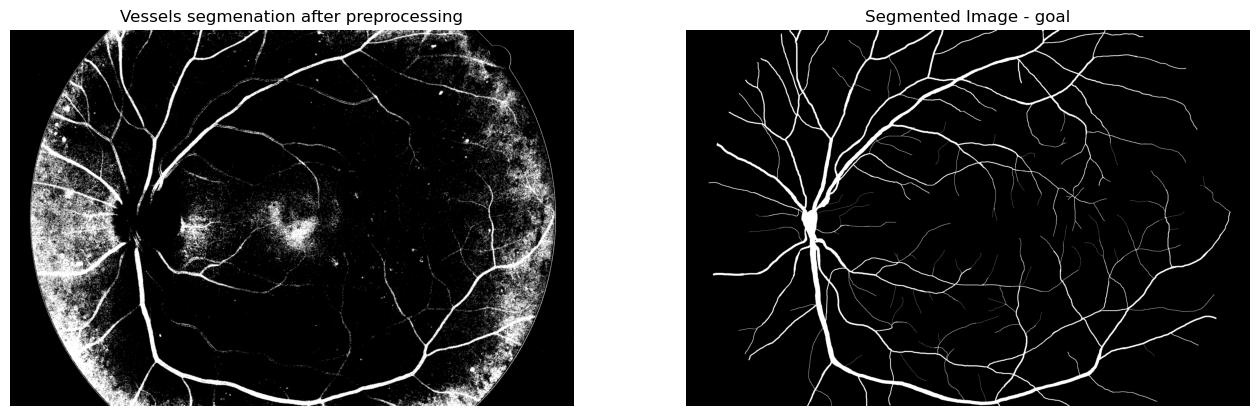

Inverted Segmented Image:
  White pixels: 1041726
  Black pixels: 7143618

Expert's segmented Image (tif_array):
  White pixels: 416282
  Black pixels: 7769062


In [69]:
tif_image_path = "HRF-database/manual1/01_dr.tif"
tif_image = Image.open(tif_image_path)

# Konwersja obrazu PIL do numpy array
tif_array = np.array(tif_image)

plt.figure(figsize=(16, 12))

plt.subplot(1, 2, 1)
plt.imshow(inverted_segmented_image, cmap='gray')
plt.title('Vessels segmenation after preprocessing')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(tif_array, cmap='gray')
plt.title('Segmented Image - goal')
plt.axis('off')

plt.show()

white_pixels_inv_seg = np.sum(inverted_segmented_image == 255)
black_pixels_inv_seg = np.sum(inverted_segmented_image == 0)

white_pixels_tif = np.sum(tif_array == 255)
black_pixels_tif = np.sum(tif_array == 0)

print("Inverted Segmented Image:")
print(f"  White pixels: {white_pixels_inv_seg}")
print(f"  Black pixels: {black_pixels_inv_seg}")

print("\nExpert's segmented Image (tif_array):")
print(f"  White pixels: {white_pixels_tif}")
print(f"  Black pixels: {black_pixels_tif}")

### 2. Ekstrakcja cech + klasyfikator do porównań z CNN (SVM / kNN / RF)

In [18]:
import cv2
import numpy as np
import os
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import Image
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from io import StringIO 
import csv

- Funkcja do ekstrakcji cech dla piksela i jego otoczenia

In [3]:
def extract_features(image, i, j):
    # Pixel
    pixel_value = image[i, j]

    # Patch 4x4
    patch = image[i-1:i+3, j-1:j+3]

    # features: jasność, średnia z otoczenia, odchylenie standardowe, kontrast
    features = [np.mean(pixel_value), np.mean(patch), np.std(patch)]

    # Grayscale patch and contrast
    gray_patch = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray_patch, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    features.append(contrast)

    return features

In [5]:
images_path = 'HRF-database/images/'
segmented_images_path = 'HRF-database/manual1/'

original_images = []
segmentation_images = []

for filename in os.listdir(images_path):
    # original image
    if filename.endswith('.JPG') or  filename.endswith('.jpg'):
        original_image = cv2.imread(os.path.join(images_path, filename))
        original_images.append(original_image)

for filename in os.listdir(segmented_images_path):
    # segmented image
    if filename.endswith('.tif'):
        segmented_image_path = os.path.join(segmented_images_path, filename)
        segmented_image = cv2.imread(segmented_image_path, cv2.IMREAD_GRAYSCALE)
        
        if segmented_image is not None:
            segmentation_images.append(segmented_image)
        else:
            print(f"Error loading segmentation image: {filename}")

print(len(original_images))
print(len(segmentation_images))

45
45


In [6]:
features_list = []
labels_list = []

step_size = 5

for original_image, segmentation_image in tqdm(zip(original_images, segmentation_images), total=len(original_images)):
    black_pixel_counter = 0  # Counter for black pixels encountered

    # Iterating through pixels
    for i in range(1, original_image.shape[0]-1, step_size):
        for j in range(1, original_image.shape[1]-1, step_size):
            # Label
            label = segmentation_image[i, j] // 255  # 0: black, 1: white

            if label == 0:
                black_pixel_counter += 1
                if black_pixel_counter % 5 != 0:  # Consider only pixels where remainder is not 0 (every 5th)
                    continue

            # Feature extraction 
            features = extract_features(original_image, i, j)
            features_list.append(features)
            labels_list.append(label)

    # Reset counter after processing each image
    black_pixel_counter = 0

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [35:33<00:00, 47.41s/it]


In [9]:
with open('features_and_labels.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(features_list)

In [10]:
# Normalizing features
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(features_list)

- Dataset

In [11]:
X = np.array(X_normalized)
y = np.array(labels_list)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

- Decision Tree Classifier

In [19]:
clf = DecisionTreeClassifier(max_depth=3, random_state=42)

clf.fit(X_train, y_train)

print("Drzewo decyzyjne:")
print(clf.tree_)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True)
Image(data=dot_data.getvalue())

- RandomForestClassifier

In [79]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

classifier.fit(X_train, y_train)

print("Random Forest Classification Report:")
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83    544378
           1       0.59      0.41      0.49    226540

    accuracy                           0.74    770918
   macro avg       0.69      0.65      0.66    770918
weighted avg       0.73      0.74      0.73    770918



- K-Nearest Neighbors

In [ ]:
classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean', algorithm='auto', random_state=42)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
print("K-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred))

### 3. Model głębokiej konwolucyjnej sieci neuronowej

### 4. Wyniki dla przykładowych instancji